In [391]:
from google.colab import drive  
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [392]:
%cd drive
%cd 'My Drive'
%cd 'IS projects'
%cd Homework5

[Errno 2] No such file or directory: 'drive'
/content/drive/My Drive/IS projects/Homework5
[Errno 2] No such file or directory: 'My Drive'
/content/drive/My Drive/IS projects/Homework5
[Errno 2] No such file or directory: 'IS projects'
/content/drive/My Drive/IS projects/Homework5
[Errno 2] No such file or directory: 'Homework5'
/content/drive/My Drive/IS projects/Homework5


In [393]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import pandas as pd
import random
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib
import sys


C1 = -0.01
C2 = -20
C3 = -100
R1 = 100
R2 = 0 #30
GAMMA = 0.9
TOTAL_EPISODE = 3000
ALPHA = 1
BETA = 1
P = 0.05
START = -2 #so it wont go back to start again
N = 15
TOTAL_ACTION = 4
UP = 0
DOWN = 2
RIGHT = 3
LEFT = 1
X = 1
Y = 0
MIN = 0.01
DECAY_FACTOR = 0.99
GET_BACK_PUNISHMENT = 10
STARTING = np.array([0, 0])
GOAL = np.array([8, 14])  

In [442]:
class Environment():
  def __init__(self, maze_map):
    self.reward_dictionary = {0: C1, 1: START, 2: C2, 3: R1, 4:R2, 5:C3}
    self.movement_dictionary = {'Up': 0, 'Left' : 1, 'Down' : 2, 'Right' : 3}
    self.maze_map = maze_map
    self.reward_map = None
    self.move_map = np.ones((N, N, TOTAL_ACTION))

  def map_rewards(self):
    mapped_rewards = [self.reward_dictionary[self.maze_map[i, j]] for i in range(N) for j in range(N)]
    self.reward_map =  np.array(mapped_rewards).reshape((N, N))
  

  def available_moves(self):
    self.move_map[0, :, self.movement_dictionary['Up']] = 0  
    self.move_map[N - 1, :, self.movement_dictionary['Down']] = 0  
    self.move_map[:, 0, self.movement_dictionary['Left']] = 0  
    self.move_map[:, N - 1, self.movement_dictionary['Right']] = 0  

  def take_step(self, curr_state, direction):
    next_state = np.zeros(2).astype(int)
    if direction == UP : next_state[Y], next_state[X] = curr_state[Y] - 1, curr_state[X]
    elif direction == LEFT : next_state[Y],  next_state[X] = curr_state[Y], curr_state[X] - 1
    elif direction == DOWN : next_state[Y], next_state[X] = curr_state[Y] + 1, curr_state[X]
    elif direction == RIGHT : next_state[Y],  next_state[X] = curr_state[Y], curr_state[X] + 1
    return next_state

  def step(self, curr_state, direction):
    next_state = self.take_step(curr_state, direction)
    reward = self.reward_map[next_state[Y], next_state[X]]
    done = False
    if np.array_equal(next_state, GOAL): done = True
    return next_state, reward, done 

  def modify_reward_map(self, next_state) : self.reward_map[next_state[Y], next_state[X]] -= 5
  def original_map(self) : self.map_rewards()

  


### Reading the data

In [396]:
def read_data(filename): return pd.read_csv(filename, index_col = None, header = None).to_numpy()

In [513]:
class QlearningAgent():

  def __init__(self, env):
    self.env = env
    self.Q = np.zeros(shape=[N, N, TOTAL_ACTION], dtype = np.float32)
    self.Q_learning_score = []
    self.gamma = GAMMA
    self.alpha = ALPHA
    self.total_path = []


  def softmax(self, current_state, dir): return np.exp(BETA * self.Q[current_state[Y], current_state[X], env.movement_dictionary[dir]])

  def reach_goal(self):
    for episode in range(1, 1+TOTAL_EPISODE):
      if episode % 1 == 0:
          print("\rEpisode {}/{}.".format(episode, TOTAL_EPISODE), end="")
          sys.stdout.flush()
          self.alpha = max(self.alpha * DECAY_FACTOR, MIN)
      curr_state = np.array([0, 0])#<-- uncomment to use original start point
      if episode in range(500):
        curr_state = (np.random.rand(2)*(N, N)).astype(int) #<-- uncomment to use exploring start
      episode_score = 0
      path = [STARTING]
      done = False
      env.original_map()
      while(not done):
        action_probability = np.zeros(TOTAL_ACTION)
        for a, dir in enumerate(env.movement_dictionary): action_probability[a] = self.softmax(curr_state, dir) if env.move_map[curr_state[Y], curr_state[X], env.movement_dictionary[dir]] else 0
        direction = np.random.choice(TOTAL_ACTION, p = action_probability/np.sum(action_probability))
        
        next_state, reward, done = env.step(curr_state, direction)
        path.append(next_state)
        episode_score += reward
        target = self.gamma * np.max(self.Q[next_state[Y], next_state[X], :]) + reward
        predict = self.Q[curr_state[Y], curr_state[X], direction]
        self.Q[curr_state[Y], curr_state[X], direction] += self.alpha *(target - predict)
        env.modify_reward_map(curr_state)
        curr_state[Y], curr_state[X] = next_state[Y], next_state[X]
      self.Q_learning_score.append(episode_score)
      self.total_path.append(path)


In [514]:
maze_map = read_data("ENV.map")
env = Environment(maze_map)
env.map_rewards()
env.available_moves()

In [ ]:
env.maze_map

In [515]:
agent = QlearningAgent(env)
reward = agent.reach_goal()

Episode 3000/3000.

In [ ]:
print('R2 = 30 - Starting Point = (0 0)\nPath taken :')
for i in range(len(agent.total_path[-1])):
  if (agent.total_path[-1][i] != GOAL).mean() : print(str(agent.total_path[-1][i]) + "->" , end="") 
  else: print(GOAL)
  if i == 23:
    print('\n')

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(TOTAL_EPISODE), agent.Q_learning_score, color = 'lightsteelblue', label = '$R2$ = $30$ - Starting Point = (0 0)')
plt.xlabel('episodes ->')
plt.ylabel('epsiode score ->')
plt.title('Q learning method')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
window_size = 100
smoothed_score = pd.Series(agent.Q_learning_score).rolling(2*window_size , min_periods = window_size).mean()
plt.plot(smoothed_score, color = 'lightsteelblue', label = '$R2$ = $30$ - Starting Point = (0 0)')
plt.xlabel("epsiode ->")
plt.ylabel("epsiode score (smoothed) -> ")
plt.title('Q learning method')
plt.legend()
plt.show()

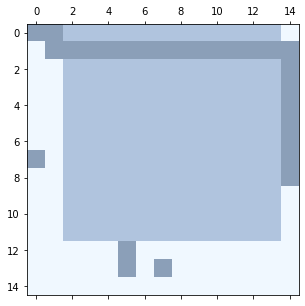

In [ ]:
maze_map = read_data("ENV.map")
env = Environment(maze_map)
env.map_rewards()
temp = env.maze_map
path = agent.total_path[-1]
temp = env.maze_map
cmap = colors.ListedColormap(['aliceblue', 'blue',  'lightsteelblue', '#555d69', 'aliceblue', '#8b9fb8'])

def change(p):
  global temp
  temp[p[Y], p[X]] = 100

def update(i):
  global path, temp
  change(path[i])
  mat.set_data(temp)
  return [mat]


fig, ax = plt.subplots(figsize = (5, 5));
mat = ax.matshow(temp, cmap = cmap)
animation.FuncAnimation(fig, update, frames = (len(path)), interval = 100, repeat = True)

In [ ]:
maze_map = read_data("ENV.map")
env = Environment(maze_map)
env.map_rewards()
temp = env.maze_map
path = agent.total_path[-1]
temp = env.maze_map
cmap = colors.ListedColormap(['aliceblue', '#555d69',  'lightsteelblue', '#555d69', '#555d69', '#8b9fb8'])

def change(p):
  global temp
  temp[p[Y], p[X]] = 100

def update(i):
  global path, temp
  change(path[i])
  mat.set_data(temp)
  return [mat]


fig, ax = plt.subplots(figsize = (5, 5));
mat = ax.matshow(temp, cmap = cmap)
myAnimation = animation.FuncAnimation(fig, update, frames = (len(path)), interval = 100, repeat = True)
myAnimation

In [489]:

# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
# myAnimation.save('im.mp4', writer=writer)